In [1]:
import os, glob, math
from pathlib import Path
from matplotlib import pyplot as plt
from moviepy.editor import VideoFileClip, AudioFileClip
import numpy as np
import librosa
import random
import colorsys

In [2]:
# Helper functions:
def random_color():
    """Generates a bright random color. adapted from:
    https://stackoverflow.com/questions/43437309/get-a-bright-random-colour-python
    """
    h,s,l = random.random(), 0.5 + random.random()/2.0, 0.4 + random.random()/5.0
    r,g,b = [int(256*i) for i in colorsys.hls_to_rgb(h,l,s)]
    return '#%02X%02X%02X' % (r,g,b)

def time_stamp(frames, fps=30):
    """Convert frames (float) to the timestamp format: HH:MM:SS:FF
    """
    hour = int(frames // (3600*fps))
    frames %= (3600*fps)
    minutes = int(frames // (60*fps))
    frames %= (60*fps)
    seconds = int(frames // fps)
    frames %= fps
    frames = int(frames)
    return f"{hour:02d}:{minutes:02d}:{seconds:02d}:{frames:02d}"

In [3]:
# Load the video and extract its audio to a file:
cwd = Path(os.getcwd())
VIDEO_PATH = cwd / 'media' / 'test_video.mp4'
TEMP_AUDIO_PATH = cwd / 'media' / 'temp_audio.wav'
clip_name= VIDEO_PATH.stem

video = VideoFileClip(str(VIDEO_PATH))
print(f"Video duration: {video.duration} s")
video.audio.write_audiofile(str(TEMP_AUDIO_PATH))
fps = video.fps
sampling_rate = video.audio.fps

chunk:   6%|▌         | 97/1724 [00:00<00:01, 969.70it/s, now=None]Video duration: 78.17 s
MoviePy - Writing audio in c:\Users\SHPro\Desktop\Programming\Smart_EDL_Generator\media\temp_audio.wav
                                                                      MoviePy - Done.


In [4]:
audio_signal, sampling_rate = librosa.load(TEMP_AUDIO_PATH, sr=sampling_rate)
audio_signal_db = librosa.core.amplitude_to_db(audio_signal, top_db=200)
audio_duration = audio_signal.shape[0] / sampling_rate
print(f"Samping rate: {sampling_rate}")
print(f"Audio duration: {audio_duration} s") 

Samping rate: 44100
Audio duration: 78.17 s


In [8]:
# Split the audio_signal into non-silent intervals:

silence_threshold = -40
silence_length = 1 # detect silences larger than this value (in seconds)
resolution = 8 # silence detection resolution e.g 4 --> 0.25 s
buffer = 0.0 # Value in seconds to add to the begining and the end of non-silenct intervals 

intervals = librosa.effects.split(audio_signal, top_db=-silence_threshold, frame_length=sampling_rate//silence_length, hop_length=sampling_rate//resolution)
intervals_seconds = intervals/sampling_rate
intervals_seconds[:,0] = intervals_seconds[:,0] - buffer
intervals_seconds[:,1] = intervals_seconds[:,1] + buffer

# detect the flagged interval:
flag_threshold = -2 # Signals above this threshold indicate the flag
intervals_flag = []

for ind, (sec_in, sec_out) in enumerate(intervals):
    signal_clip = audio_signal_db[sec_in:sec_out]
    if np.max(signal_clip) > flag_threshold:
        intervals_flag.append(ind)

intervals_to_remove = intervals[intervals_flag]

if process_code == 0:
    # Only remove silent parts:
    intervals_to_keep = intervals
elif process_code == 1:
    # Only remove flagged parts:
    intervals_to_keep = []
    intervals_to_keep.append([0, intervals_to_remove[0][0]])
    for i in range(intervals_to_remove.shape[0]-1):
        intervals_to_keep.append([intervals_to_remove[i][1], intervals_to_remove[i+1][0]])
    intervals_to_keep.append([intervals_to_remove[-1][1], audio_signal.shape[0]])
else:
    # Remove silent and flagged parts:
    intervals_to_keep = intervals[[i for i in range(intervals.shape[0]) if i not in intervals_flag]]

intervals_to_keep = np.array(intervals_to_keep) / sampling_rate

"""
# Create an EDL based on the flagged intervals
# EDL format (https://www.niwa.nu/2013/05/how-to-read-an-edl/):

001  AX  V  C  CLIP_IN_1 CLIP_OUT_1 TIMELINE_BEGIN_1 TIMELINE_END_1
001  AX  V  C  CLIP_IN_2 CLIP_OUT_2 TIMELINE_BEGIN_2 TIMELINE_END_2

TIMELINE_BEGIN_1 = 00:00:00:00
(TIMELINE_END - TIMELINE_BEGIN) = (CLIP_OUT - CLIP_IN)
TIMELINE_BEGIN_2 = TIMELINE_END_1
"""
with open(f"{VIDEO_PATH}.{fps:0.2f}.edl", "w+") as f:
    f.write(f"TITLE: {VIDEO_PATH.name}\n")
    f.write("FCM: NON-DROP FRAME\n\n")
    time_line_b = 0
    for ind, (sec_in, sec_out) in enumerate(intervals_to_keep):
        frames_in = math.floor(sec_in*fps)
        frames_out = math.floor(sec_out*fps)
        time_line_e = time_line_b + frames_out - frames_in
        f.write(f"{(ind+1):03d}  AX  V     C  {time_stamp(frames_in, fps)} {time_stamp(frames_out, fps)} {time_stamp(time_line_b, fps)} {time_stamp(time_line_e, fps)}\n")
        # f.write(f"* FROM CLIP NAME: {VIDEO_PATH.name}\n\n")
        f.write(f"{(ind+1):03d}  AX  AA    C  {time_stamp(frames_in, fps)} {time_stamp(frames_out, fps)} {time_stamp(time_line_b, fps)} {time_stamp(time_line_e, fps)}\n")
        # f.write(f"* FROM CLIP NAME: {VIDEO_PATH.name}\n\n")
        f.write(f"{(ind+1):03d}  AX  NONE  C  {time_stamp(frames_in, fps)} {time_stamp(frames_out, fps)} {time_stamp(time_line_b, fps)} {time_stamp(time_line_e, fps)}\n")
        # f.write(f"* FROM CLIP NAME: {VIDEO_PATH.name}\n\n")
        time_line_b = time_line_e

In [9]:
intervals_seconds[intervals_flag]

array([[ 7.49931973, 34.87183673],
       [51.74530612, 71.86848073]])

In [21]:
# Only remove silent parts:
intervals_to_keep = intervals

# Only remove flagged parts:
intervals_to_keep = []
intervals_to_keep.append([0, intervals_to_remove[0][0]])
for i in range(intervals_to_remove.shape[0]-1):
    intervals_to_keep.append([intervals_to_remove[i][1], intervals_to_remove[i+1][0]])
intervals_to_keep.append([intervals_to_remove[-1][1], audio_signal.shape[0]])

# Remove silent and flagged parts:
intervals_to_keep = intervals[[i for i in range(intervals.shape[0]) if i not in intervals_flag]]

intervals_to_keep = np.array(intervals_to_keep) / sampling_rate

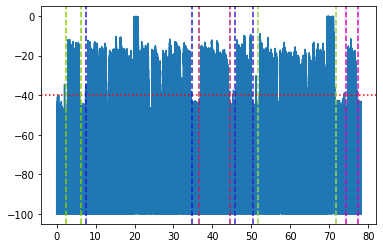

In [11]:
xs = np.linspace(0,audio_duration, audio_signal.shape[0])
plt.plot(xs, audio_signal_db);

plt.axhline(y=-40, color='r', linestyle=':')
for sec_in, sec_out in intervals_seconds:
    color = random_color()
    plt.axvline(x=sec_in, color=color, linestyle='--')
    plt.axvline(x=sec_out, color=color, linestyle='--')